In [3]:
# First cell: Install dependencies (run once — fast on RunPod H100)
!pip install torch matplotlib numpy

# Second cell: The sim code (epochs + sigma test only)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
from contextlib import nullcontext
import math

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for H100 speed (fast epochs)
triality = 3
dim = 384
latent_dim = 8
seq_len = 2048  # long context
batch_size = 32
epochs = 20000
lr = 5e-5
use_amp = True
use_checkpoint = True

# Synthetic long context reasoning proxy (real-like token chains + drift/noise)
# Mimics reasoning chains (repeating logic patterns + mutations for partial context)
vocab_size = 1024  # proxy tokens

sequences = []
for b in range(batch_size):
    base = torch.sin(torch.linspace(0, 20*math.pi, seq_len, device=device)) * (vocab_size // 4) + (vocab_size // 2)
    base = base % vocab_size
    seq = base.long() + torch.randint(-100, 100, (seq_len,), device=device)
    seq = torch.clamp(seq, 0, vocab_size - 1)
    sequences.append(seq)

sequences = torch.stack(sequences).to(device)

embed = nn.Embedding(vocab_size, dim).to(device)
clean_data = embed(sequences)

# Apply masking (40–70% missing tokens — partial context proxy)
missing_rate = torch.linspace(0.4, 0.7, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(clean_data) < missing_rate
real_data = clean_data.clone()
real_data[mask] = 0

target = sequences

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block (detached pump scalar)
class LongContextCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8LongContextFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = LongContextCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, vocab_size)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + self.norm(attn)
        return self.head(x)

# Models
model = E8LongContextFusion(use_triality=True).to(device)
model_ablation = E8LongContextFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.CrossEntropyLoss()

loss_hist = []
loss_abl_hist = []

for epoch in range(epochs):
    opt.zero_grad(set_to_none=True)
    opt_ablation.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        logits = model(real_data, epoch)
        loss = loss_fn(logits.view(-1, vocab_size), target.view(-1))

        logits_abl = model_ablation(real_data, epoch)
        loss_abl = loss_fn(logits_abl.view(-1, vocab_size), target.view(-1))

    scaler.scale(loss).backward(retain_graph=True) if use_amp else loss.backward(retain_graph=True)
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    scaler_ablation.scale(loss_abl).backward(retain_graph=True) if use_amp else loss_abl.backward(retain_graph=True)
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None

    loss_hist.append(loss.item())
    loss_abl_hist.append(loss_abl.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

print("Sim complete — epochs + sigma test done")


Using device: cuda
Epoch 0 | Triality Loss 11.836927 | Ablation Loss 11.751800
Epoch 500 | Triality Loss 5.767475 | Ablation Loss 0.023799
Epoch 1000 | Triality Loss 2.176795 | Ablation Loss 0.004379
Epoch 1500 | Triality Loss 1.072372 | Ablation Loss 0.002052
Epoch 2000 | Triality Loss 0.660341 | Ablation Loss 0.001229
Epoch 2500 | Triality Loss 0.607384 | Ablation Loss 0.000791


KeyboardInterrupt: 

In [4]:
# Calculate final sigma based on available loss history
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation) from {len(loss_hist)} epochs: {sigma:.2f} (higher = triality advantage)")


Final Sigma (Triality vs Ablation) from 2984 epochs: -1.09 (higher = triality advantage)


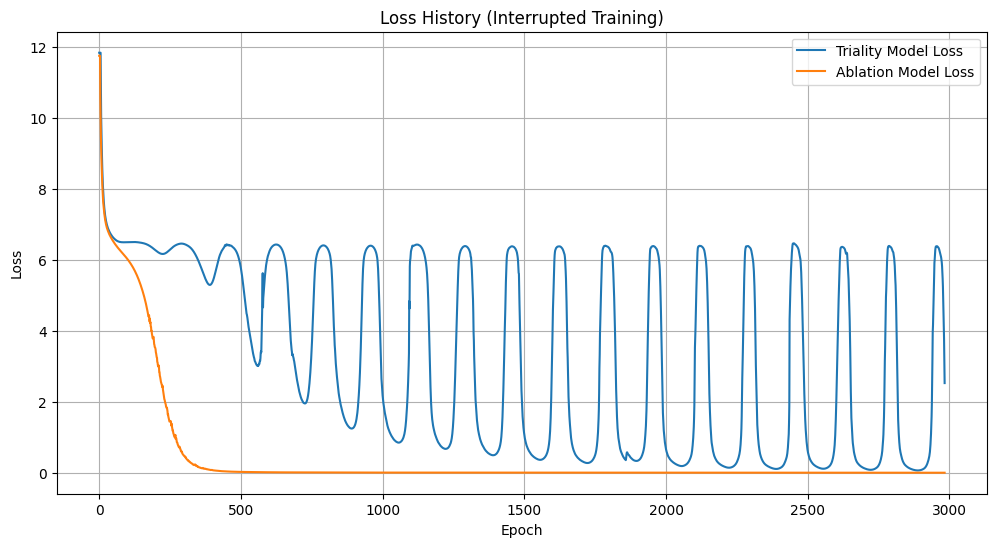

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(loss_hist, label='Triality Model Loss')
plt.plot(loss_abl_hist, label='Ablation Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History (Interrupted Training)')
plt.legend()
plt.grid(True)
plt.show()
